# Attack on Adult using a Decision Tree and the noisy dataset's points closest to the instance

In [1]:
from pathlib import Path
import sys
from numba import njit

UTILS_RELATIVE_PATH = "../../../../"
sys.path.append(UTILS_RELATIVE_PATH)

MLEM_RELATIVE_PATH = "../../../../.."
sys.path.append(MLEM_RELATIVE_PATH)

LIME_RELATIVE_PATH = "../../../../../lime/"
sys.path.append(LIME_RELATIVE_PATH)

OUTPUT_FOLDER = Path("experiment_output")
OUTPUT_FOLDER.mkdir(exist_ok=True)

import logging
logging.disable('DEBUG')


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
import numpy as np
import scipy.spatial.distance as distance
import multiprocessing

np.random.seed(4321)
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from lime.lime_tabular import LimeTabularExplainer # type: ignore
from mlem.utilities import generate_balanced_dataset, save_pickle_bz2, load_pickle_bz2, save_txt

importing the experiment utilities and the mlem module

# Loading the Adult data

loading the Adult RandomForest and the dictionary with all the useful data

In [3]:
from utils.dataloading.adult import load_adult_data, load_adult_randomforest # type: ignore

BB = load_adult_randomforest()
BB_DATA = load_adult_data()

print(classification_report(BB_DATA['y_test'], BB.predict(BB_DATA['X_test'])))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      8157
           1       0.79      0.61      0.69      2690

    accuracy                           0.86     10847
   macro avg       0.84      0.78      0.80     10847
weighted avg       0.86      0.86      0.86     10847



# Creating the explainer

In [4]:
explainer_training_data = BB_DATA['X_train']
explainer = LimeTabularExplainer(training_data=explainer_training_data, categorical_features=[i for (i, el) in enumerate(BB_DATA['categorical_features_mask']) if el], random_state=123)

def generate_data_lime(x, num_samples):
    return explainer.data_inverse(x, num_samples+1, 'gaussian')[1][1:]

def filter_elements_std(elems, x, std=3):
    df_ = pd.DataFrame(elems)
    df_['Dist'] = distance.cdist(elems, [x])
    mean = df_.Dist.mean()
    dev = df_.Dist.std()
    closest = df_[df_['Dist'] < mean+std*dev]
    return closest.drop(labels=['Dist'], axis=1)

# Generating the lime datasets

In [5]:
test_representatives_x = BB_DATA['X_attack_3_per_quantile']
test_representatives_y = BB_DATA['y_attack_3_per_quantile']
n_datasets = len(test_representatives_x)

In [6]:
def generate_and_save(index, instance):
    # wrapper of the above functions to be able to generate the datasets in parallel
    output_path = OUTPUT_FOLDER / f"{index}"
    output_path.mkdir(exist_ok=True)
    balanced_dataset = generate_balanced_dataset(instance, 5000, BB, generate_data_lime, filter_elements_std)
    balanced_dataset.to_csv(output_path / "lime_generated.csv", index=False)
    with open(output_path / "instance.npy", "wb") as f:
        np.save(f, instance)


if not any([Path(OUTPUT_FOLDER / f"{j}" / "lime_generated.csv").exists() for j in range(len(test_representatives_x))]):
    with multiprocessing.Pool(processes=8) as pool:
        pool.starmap(generate_and_save, [*enumerate(test_representatives_x)])
else:
    print("The lime generated datasets already exist")

The lime generated datasets already exist


# Creating the Decision Trees

Creating the decision trees <span style="color:red"> if they don't already exist </span>.

In [7]:
from mlem.utilities import create_decision_tree

def train_decision_tree(datapath, model_name):
    lime_dataset = pd.read_csv(datapath / "lime_generated.csv")
    X_train, X_test, y_train, y_test = train_test_split(lime_dataset.drop('Target', axis=1).to_numpy(), lime_dataset.Target.to_numpy(), test_size=0.33, random_state=42)
    model_path = datapath / model_name
    if not model_path.exists():
        dt = create_decision_tree(X_train, y_train, use_halving=True) 
        save_pickle_bz2(model_path, dt)
        save_txt(datapath / "dt_classification_report.txt", classification_report(y_test, dt.predict(X_test)))

In [8]:
models_name = "dt.bz2"
if not any([Path(OUTPUT_FOLDER / f"{j}" / "dt.bz2").exists() for j in range(len(test_representatives_x))]):
    with multiprocessing.Pool(8) as pool:
        pool.starmap(train_decision_tree, [(Path(OUTPUT_FOLDER / f"{i}"), models_name) for i in range(len(test_representatives_x))])
else:
    print("The DecisionTrees already exist")

The DecisionTrees already exist


# Attack on the Decision Trees to create the attack models

Attack on the decision trees using the <span style="background: green">noisy dataset's closest point to the instance</span> labeled by the decision trees to create the shadow models.

In [9]:
noisy_dataset_x = pd.DataFrame(BB_DATA['X_validation_noisy'])
noisy_dataset_y = pd.DataFrame(BB_DATA['y_validation_noisy'])
categorical_features_mask = BB_DATA['categorical_features_mask']

Creating the shadow models and the attack models.

In [10]:
from mlem.shadow_models import ShadowModelsManager
from mlem.utilities import create_adaboost
from mlem.attack_models import AttackModelsManager, AttackStrategy

In [11]:
def compute_statistics_local_model(dataset, true_y, local_model, black_box, output_folder, filename):
    local_y = local_model.predict(dataset.to_numpy())
    local_bb = black_box.predict(dataset.to_numpy())

    report_local = classification_report(true_y.to_numpy(), local_y)
    report_bb    = classification_report(true_y.to_numpy(), local_bb)

    fidelity = str(pd.DataFrame(local_y == local_bb).value_counts(normalize=True))

    with open(output_folder / filename, "w") as f:
        
        f.write("local model\n")
        f.write(report_local)

        f.write("\nblack box\n")
        f.write(report_bb)

        f.write("\nFidelity between the local model and the black box\n")
        f.write(fidelity)

Run the attack only if it hasn't already been run

In [12]:
if not any([(OUTPUT_FOLDER / f"{i}" / "attack").exists() for i in range(len(test_representatives_x))]):
    
    for ind, path in enumerate([OUTPUT_FOLDER / f"{i}" for i in range(len(test_representatives_x))]):
        # load the local tree and label the noisy dataset
        local_tree = load_pickle_bz2(path / "dt.bz2")

        # compute fidelity and performances on the noisy dataset.
        # NOTE: The labels associated with the noisy dataset are the same of the clean one.

        filtered_noisy = filter_elements_std(noisy_dataset_x.copy(), test_representatives_x[ind])
        
        compute_statistics_local_model(noisy_dataset_x, noisy_dataset_y, local_tree, BB, path, "statistics_noisy.txt")

        x_attack = filtered_noisy.to_numpy()    
        y_attack = local_tree.predict(x_attack)

        path_shadow = str(path / "shadow")

        shadow_models = ShadowModelsManager(
            n_models=4,
            results_path=path_shadow,
            test_size=0.5,
            random_state=123,
            model_creator_fn=create_adaboost,
            categorical_mask=categorical_features_mask
        )
        # x_attack is the noisy dataset
        shadow_models.fit(x_attack, y_attack)

        # extracting the dataset for the attack models
        attack_models_dataset = shadow_models.get_attack_dataset()

        # saving the attack dataset
        attack_models_dataset.to_csv(path / "attack_models_train_dataset.csv", index=False)

        # Creating the attack model for each label using Adaboost
        path_attack = str(path / "attack")
        attack_models = AttackModelsManager(
                results_path=path_attack, model_creator_fn=create_adaboost, attack_strategy=AttackStrategy.ONE_PER_LABEL
        )
        
        attack_models.fit(attack_models_dataset)
else:
    print("The attack models already exist")

The attack models already exist


By looking at the test reports of the attack models, it seems that they <span style="background: green">perform better on the class 1</span> with an accuracy of $\simeq .62$, while the accuracy on the class 0 is $\simeq .51$.

# Creating the ensembles

In [13]:
from mlem.ensemble import HardVotingClassifier, SoftVotingClassifier, KMostSureVotingClassifier
from utils.attack_evaluation import evaluate_attack

In [14]:
attack_models_0 = [load_pickle_bz2(OUTPUT_FOLDER / f"{i}" / "attack" / "0" / "model.pkl.bz2") for i in range(len(test_representatives_x))]
attack_models_1 = [load_pickle_bz2(OUTPUT_FOLDER / f"{i}" / "attack" / "1" / "model.pkl.bz2") for i in range(len(test_representatives_x))]

## Hard Voting

In [15]:
hv0 = HardVotingClassifier(classifiers=attack_models_0)
hv1 = HardVotingClassifier(classifiers=attack_models_1)

report full
              precision    recall  f1-score   support

          in       0.70      0.23      0.35     25088
         out       0.30      0.77      0.43     10775

    accuracy                           0.39     35863
   macro avg       0.50      0.50      0.39     35863
weighted avg       0.58      0.39      0.37     35863


Class 0
              precision    recall  f1-score   support

          in       0.67      0.05      0.09     20133
         out       0.30      0.95      0.46      8694

    accuracy                           0.32     28827
   macro avg       0.49      0.50      0.27     28827
weighted avg       0.56      0.32      0.20     28827


Class 1
              precision    recall  f1-score   support

          in       0.70      1.00      0.83      4955
         out       0.30      0.00      0.01      2081

    accuracy                           0.70      7036
   macro avg       0.50      0.50      0.42      7036
weighted avg       0.58      0.70      0.58 

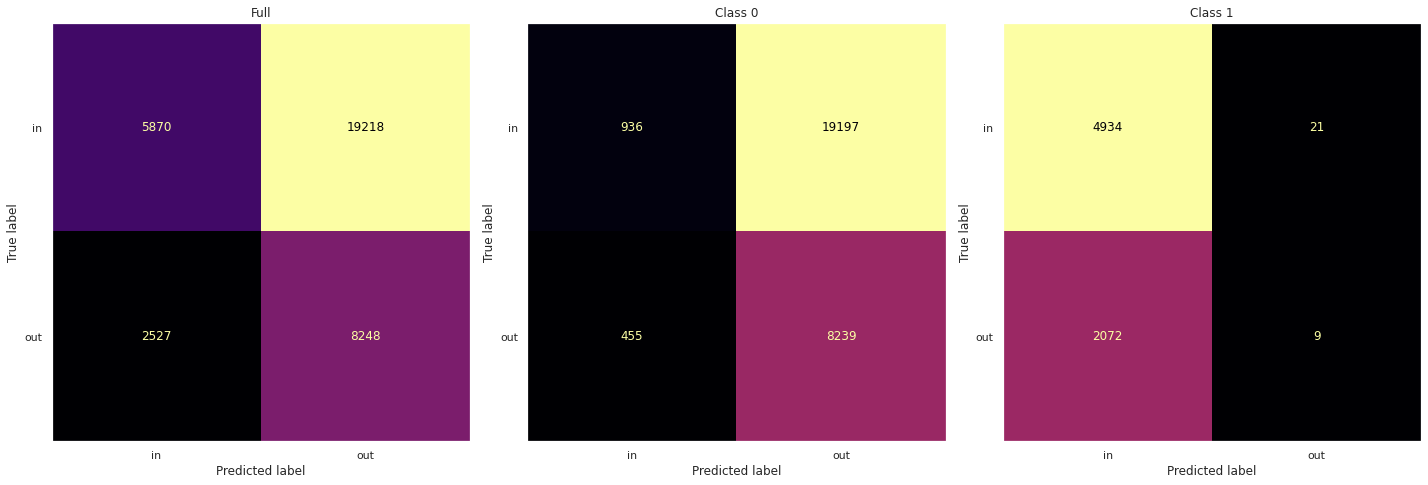

In [16]:
evaluate_attack(hv0, hv1, BB, BB_DATA)

## Soft Voting

In [17]:
sv0 = SoftVotingClassifier(classifiers=attack_models_0)
sv1 = SoftVotingClassifier(classifiers=attack_models_1)

report full
              precision    recall  f1-score   support

          in       0.70      0.22      0.34     25308
         out       0.30      0.78      0.43     10847

    accuracy                           0.39     36155
   macro avg       0.50      0.50      0.39     36155
weighted avg       0.58      0.39      0.37     36155


Class 0
              precision    recall  f1-score   support

          in       0.69      0.04      0.07     20353
         out       0.30      0.96      0.46      8766

    accuracy                           0.32     29119
   macro avg       0.50      0.50      0.26     29119
weighted avg       0.57      0.32      0.19     29119


Class 1
              precision    recall  f1-score   support

          in       0.70      1.00      0.82      4955
         out       0.28      0.00      0.01      2081

    accuracy                           0.70      7036
   macro avg       0.49      0.50      0.42      7036
weighted avg       0.58      0.70      0.58 

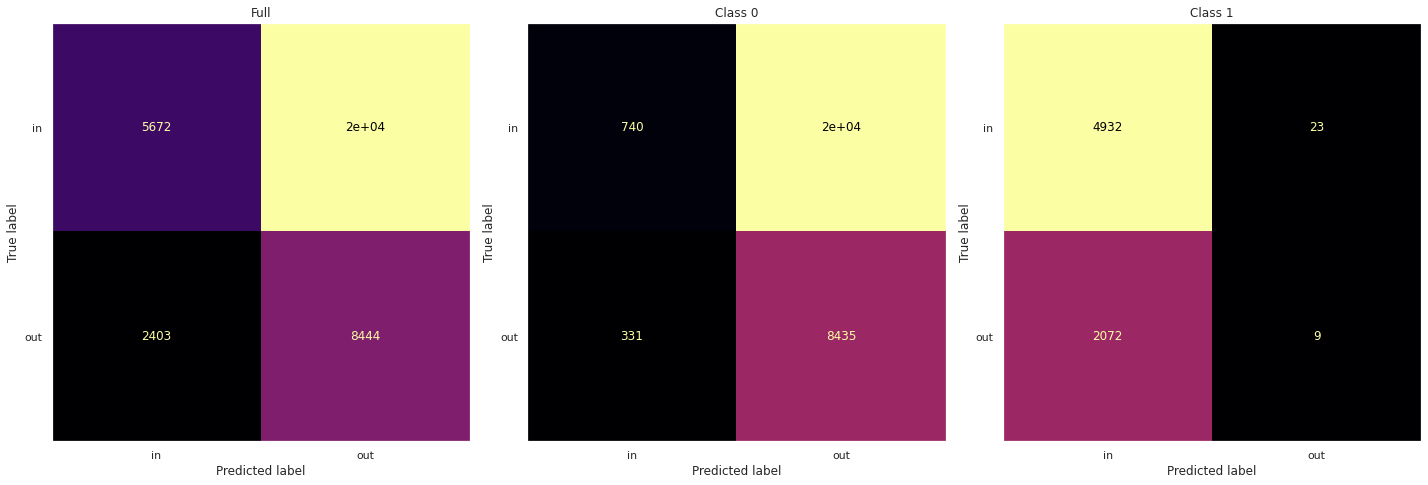

In [18]:
evaluate_attack(sv0, sv1, BB, BB_DATA)